# Usefule resources:
## OpenCV NLM Example:
https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html

## IPOL
http://www.ipol.im/pub/art/2011/bcm_nlm/

## 2005 IEEE NLM article
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1467423

## NLM OpenCV GitHub:
- https://github.com/opencv/opencv/tree/4.x/modules/photo/src
- https://github.com/opencv/opencv/blob/4.x/modules/photo/src/fast_nlmeans_denoising_invoker.hpp (most important)
- https://github.com/opencv/opencv/blob/4.x/modules/photo/src/fast_nlmeans_denoising_invoker_commons.hpp (utils)

## Image sequencies 
https://static.aminer.org/pdf/PDF/000/317/196/spatio_temporal_wiener_filtering_of_image_sequences_using_a_parametric.pdf  
Page 5: *Unfortunately, this method fails when the standard deviation of the noise exceeds
the contrast of edges.*  
Mostly section 7.1

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.io import imread, imshow
import cv2 as cv
from nlm import show_original_with_denoised, create_padded_img, denoise_nlm, denoise_nlm_with_history_averaging, compare_img_quality, denoise_nlm_with_smart_history
from utils import shift_gt_img
from matplotlib import pyplot as plt
import torch
import pandas as pd



prefix = "/home/martinb/SCHOOL/pv162_project/"
#samples_dark_path = prefix + "data/input_images/samples_dark/"
samples_default_folder = prefix + "data/input_images/100x100_100ns_default/"
samples_shifted_folder = prefix + "data/input_images/100x100_100ns_shifted/"
gt_img_path =  prefix + "data/input_images/cropped_sample1024_512x512.png"

def crop(img, offset=0):
    return img[5+offset:55+offset, 80+offset:130+offset]

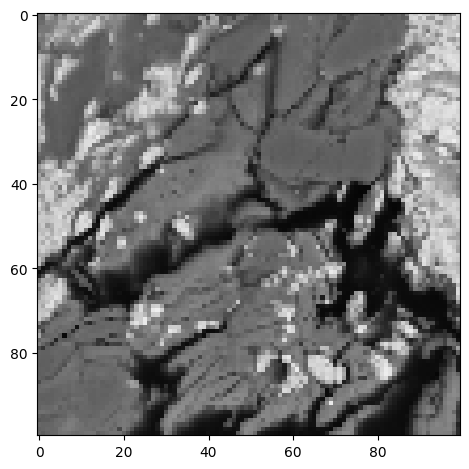

In [2]:
gt_img = shift_gt_img(imread(gt_img_path, as_gray=True).astype(np.uint8), 0)
gt_img = gt_img.astype(np.float64) / 255
imshow(gt_img)

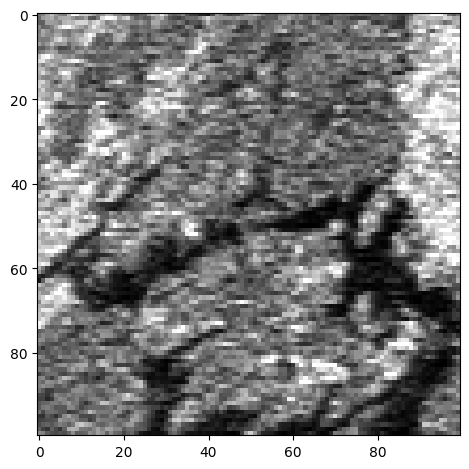

In [3]:
noisy_img = imread(samples_shifted_folder + f"0.png", as_gray=True).astype(np.float64) / 255
imshow(noisy_img)

In [4]:
# PARAMETERS
sd = 0.2632 # estimated using R
strength = 0.35*sd #0.4 * sd # 0.078 
compare_window_size = 7 # ODD
search_window_size = 35 # ODD! bigger than compare win

In [105]:
denoised_img = denoise_nlm(noisy_img, search_window_size, compare_window_size, strength, sd)

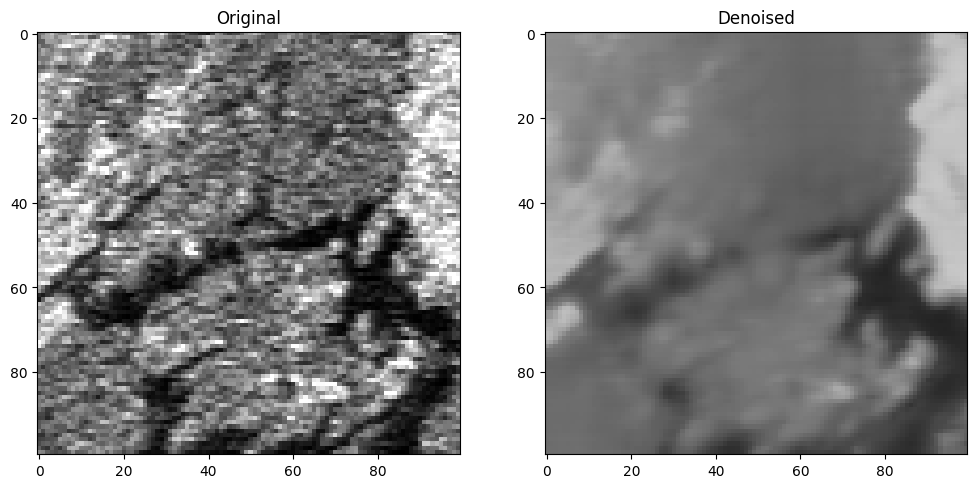

In [106]:
show_original_with_denoised(noisy_img, denoised_img)

In [107]:
# quality of the denoised img
compare_img_quality(gt_img, noisy_img, denoised_img)

# PSNR
  63.34962980600444
  64.99949594254987
# SSIM
  0.3476413603265645
  0.2345222795333143
# MSE
  0.03006888888888889
  0.020565097204247013


In [109]:
# generated values
folder = "/home/martinb/Trash/results/"
denoised_h0 = imread(folder + "nlm_h0_sw19_cw9.png", as_gray=True).astype(np.float64) / 255
denoised_h1 = imread(folder + "nlm_smart_h1_sw19_cw9.png", as_gray=True).astype(np.float64) / 255
denoised_h64 = imread(folder + "nlm_smart_h64_sw19_cw9.png", as_gray=True).astype(np.float64) / 255

compare_img_quality(gt_img, noisy_img, denoised_h0)

# PSNR
  63.34962980600444
  65.18937078812867
# SSIM
  0.3476413603265645
  0.23431754481958297
# MSE
  0.03006888888888889
  0.01968535640138408


In [110]:
compare_img_quality(gt_img, noisy_img, denoised_h1)

# PSNR
  63.34962980600444
  65.24181994235687
# SSIM
  0.3476413603265645
  0.22549829724867967
# MSE
  0.03006888888888889
  0.019449048827374086


In [111]:
compare_img_quality(gt_img, noisy_img, denoised_h64)

# PSNR
  63.34962980600444
  64.79495702833566
# SSIM
  0.3476413603265645
  0.24124244390933522
# MSE
  0.03006888888888889
  0.02155681814686659


# Results

In [5]:
# first some charts
# nlm with smart history on NOT shifted data
df = pd.read_csv("/home/martinb/SCHOOL/pv162_project/data/results/history_nlm_results.csv")
COMPARE_WINDOW_SIZE = 9

folder_prefix = "~/SCHOOL/pv162_project/data/results/default/"
sw_values = [19, 27, 35, 43]
final_images_smart_nlm = {}
for _sw in df['sw']:
    sw = int(_sw)
    final_images_smart_nlm[sw] = {}
    for _h in df['history']:
        h = int(_h)
        if h == 0:
            final_images_smart_nlm[sw][h] = (imread(folder_prefix + f"nlm_h0_sw{sw}_cw{COMPARE_WINDOW_SIZE}.png", as_gray=True).astype(np.uint8))
        else:
            final_images_smart_nlm[sw][h] = (imread(folder_prefix + f"nlm_smart_h{h}_sw{sw}_cw{COMPARE_WINDOW_SIZE}.png", as_gray=True).astype(np.uint8))

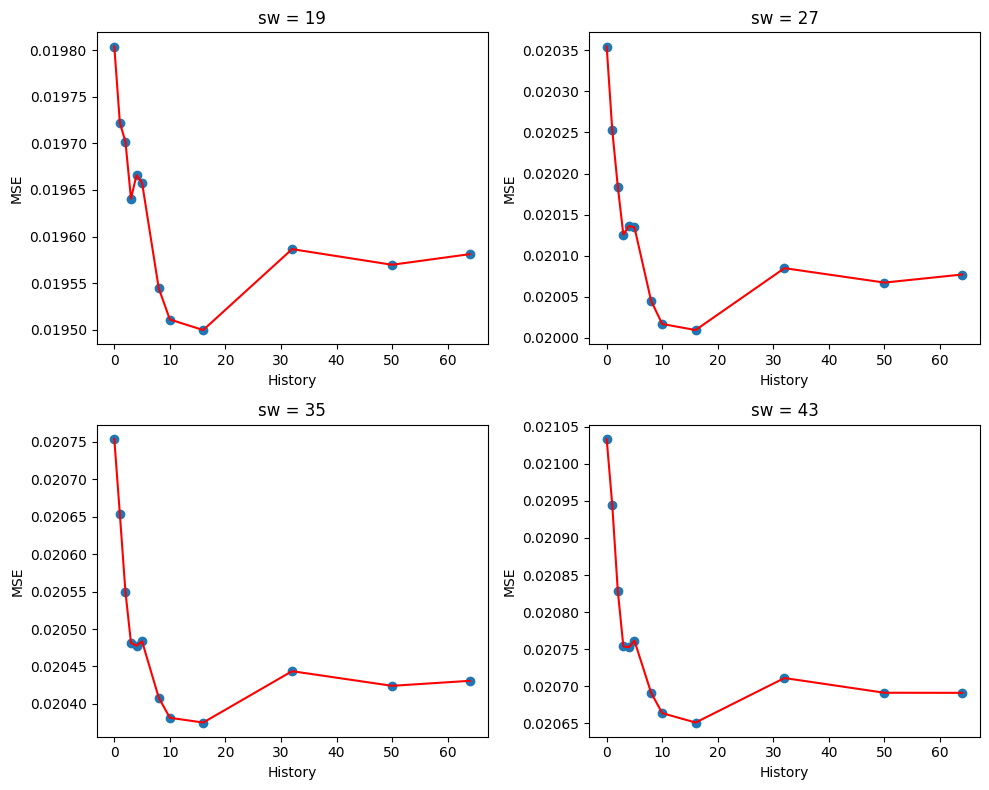

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Define the values of 'sw' to plot
sw_values = [19, 27, 35, 43]

# Iterate over the subplots and plot 'history' vs 'MSE' for each 'sw' value
for i, ax in enumerate(axes.flat):
    sw = sw_values[i]
    data = df[df['sw'] == sw].copy()

    ax.scatter(data['history'], data['MSE'])
    ax.plot(data['history'], data['MSE'], color='r')
    ax.set_xlabel('History')
    ax.set_ylabel('MSE')
    ax.set_title(f'sw = {sw}')
    #ax.set_xticks(data['history'])
    #ax.set_yticks(data['MSE'])
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [46]:
sw_values = [19, 27, 35, 43]
# Define the values of 'sw' to check
sw_values = [19, 27, 35, 43]

# Iterate over the 'sw' values and print the row with minimal MSE for each 'sw'
for sw in sw_values:
    filtered_data = df[df['sw'] == sw]
    min_mse_row = filtered_data.loc[filtered_data['MSE'].idxmin()]
    print(f"Maximal value of MSE for {sw} was {min_mse_row['MSE']}, for hsitory {min_mse_row['history']}")

Maximal value of MSE for 19 was 0.019499748912758, for hsitory 16.0
Maximal value of MSE for 27 was 0.0200095871665967, for hsitory 16.0
Maximal value of MSE for 35 was 0.0203751931686271, for hsitory 16.0
Maximal value of MSE for 43 was 0.0206511644981995, for hsitory 16.0


Text(0.5, 1.0, 'sw = 43')

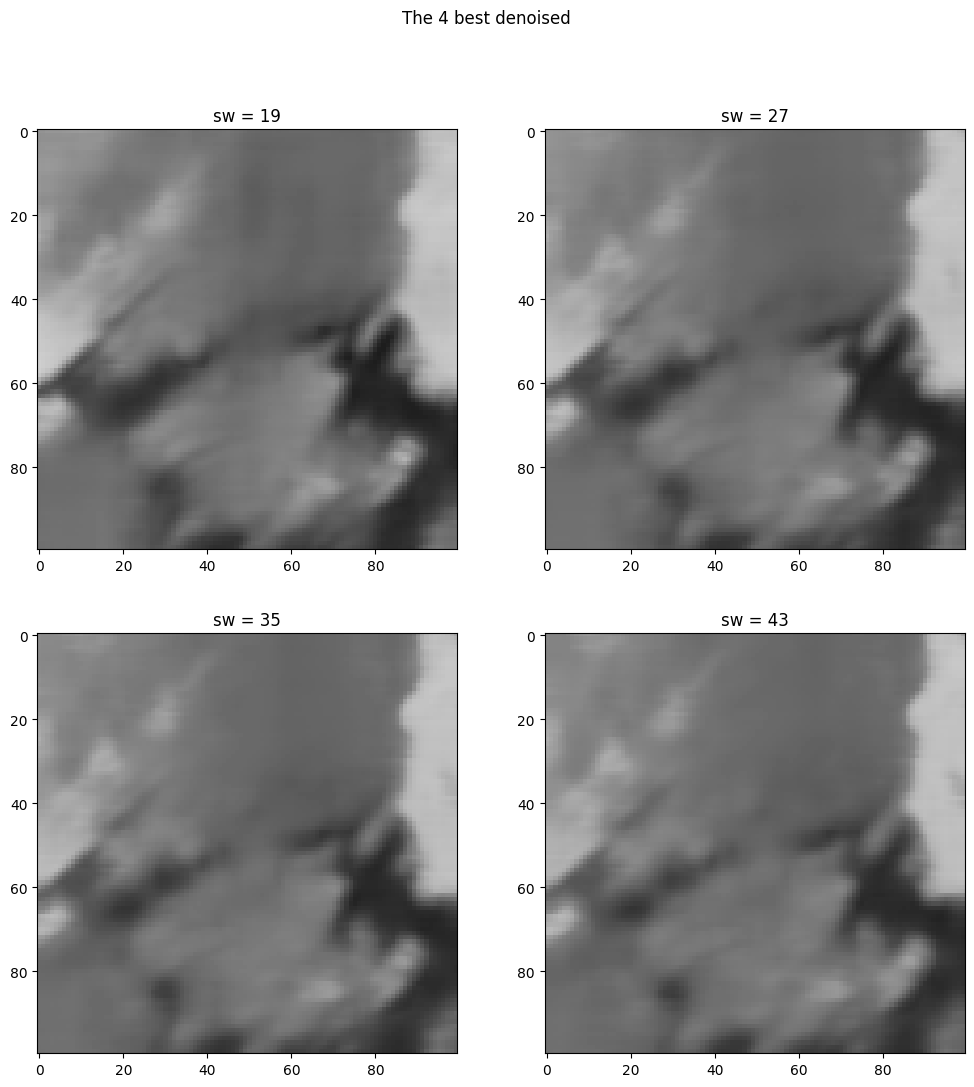

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle("The 4 best denoised")
axes[0][0].imshow(final_images_smart_nlm[19][16], cmap='gray', vmin=0, vmax=255)
axes[0][0].set_title("sw = 19")
axes[0][1].imshow(final_images_smart_nlm[27][16], cmap='gray', vmin=0, vmax=255)
axes[0][1].set_title("sw = 27")

axes[1][0].imshow(final_images_smart_nlm[35][16], cmap='gray', vmin=0, vmax=255)
axes[1][0].set_title("sw = 35")
axes[1][1].imshow(final_images_smart_nlm[43][16], cmap='gray', vmin=0, vmax=255)
axes[1][1].set_title("sw = 43")

Text(0.5, 1.0, 'history = 16')

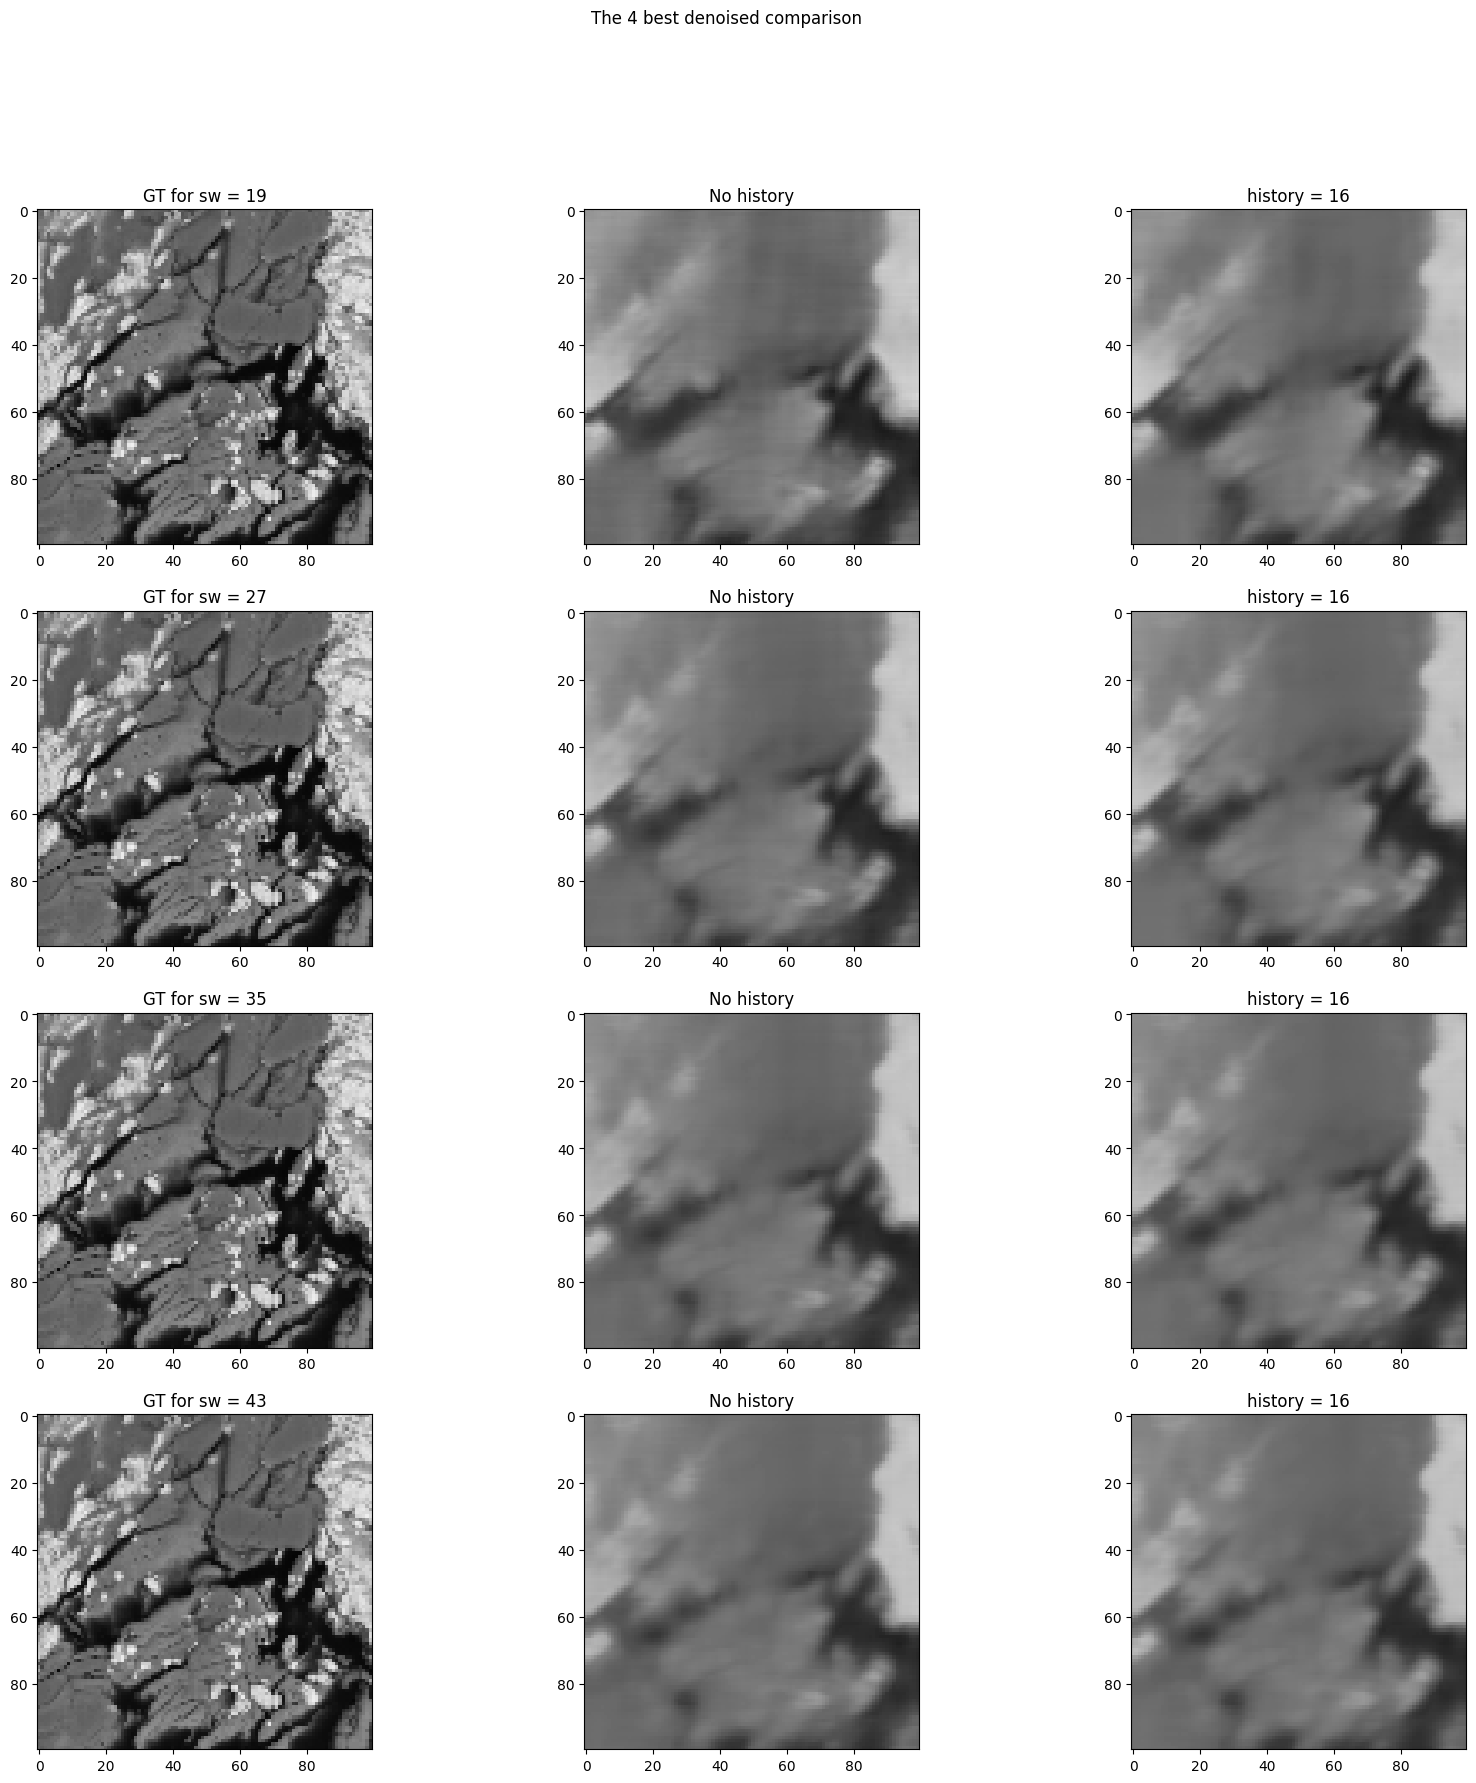

In [73]:
fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle("The 4 best denoised comparison")
axes[0][0].imshow(gt_img * 255, cmap='gray', vmin=0, vmax=255)
axes[0][0].set_title("GT for sw = 19")
axes[0][1].imshow(final_images_smart_nlm[19][0], cmap='gray', vmin=0, vmax=255)
axes[0][1].set_title("No history")
axes[0][2].imshow(final_images_smart_nlm[19][16], cmap='gray', vmin=0, vmax=255)
axes[0][2].set_title("history = 16")

axes[1][0].imshow(gt_img * 255, cmap='gray', vmin=0, vmax=255)
axes[1][0].set_title("GT for sw = 27")
axes[1][1].imshow(final_images_smart_nlm[27][0], cmap='gray', vmin=0, vmax=255)
axes[1][1].set_title("No history")
axes[1][2].imshow(final_images_smart_nlm[27][16], cmap='gray', vmin=0, vmax=255)
axes[1][2].set_title("history = 16")

axes[2][0].imshow(gt_img * 255, cmap='gray', vmin=0, vmax=255)
axes[2][0].set_title("GT for sw = 35")
axes[2][1].imshow(final_images_smart_nlm[35][0], cmap='gray', vmin=0, vmax=255)
axes[2][1].set_title("No history")
axes[2][2].imshow(final_images_smart_nlm[35][16], cmap='gray', vmin=0, vmax=255)
axes[2][2].set_title("history = 16")

axes[3][0].imshow(gt_img * 255, cmap='gray', vmin=0, vmax=255)
axes[3][0].set_title("GT for sw = 43")
axes[3][1].imshow(final_images_smart_nlm[43][0], cmap='gray', vmin=0, vmax=255)
axes[3][1].set_title("No history")
axes[3][2].imshow(final_images_smart_nlm[43][16], cmap='gray', vmin=0, vmax=255)
axes[3][2].set_title("history = 16")

### nlm with smart history on NOT shifted data


In [6]:
df = pd.read_csv("/home/martinb/SCHOOL/pv162_project/data/results/history_nlm_results.csv")
COMPARE_WINDOW_SIZE = 9

folder_prefix = "~/SCHOOL/pv162_project/data/results/shifted/"
sw_values = [19, 27, 35, 43]
final_images_smart_nlm = {}
for _sw in df['sw']:
    sw = int(_sw)
    final_images_smart_nlm[sw] = {}
    for _h in df['history']:
        h = int(_h)
        if h == 0:
            final_images_smart_nlm[sw][h] = (imread(folder_prefix + f"nlm_h0_sw{sw}_cw{COMPARE_WINDOW_SIZE}.png", as_gray=True).astype(np.uint8))
        else:
            final_images_smart_nlm[sw][h] = (imread(folder_prefix + f"nlm_smart_h{h}_sw{sw}_cw{COMPARE_WINDOW_SIZE}.png", as_gray=True).astype(np.uint8))

FileNotFoundError: No such file: '/home/martinb/SCHOOL/pv162_project/data/results/shifted/nlm_smart_h64_sw35_cw9.png'

In [48]:
# load history
count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255))

NameError: name 'samples_dark_path' is not defined

In [ ]:
i = 0
img_0 = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)
denoised_img_0 = denoise_nlm_with_history(img_0, history, search_window_size, compare_window_size, strength, sd)

In [41]:
show_original_with_denoised(img_0, denoised_img_0)

NameError: name 'img_0' is not defined

In [51]:
compare_img_quality(img_0, gt_img, denoised_img_0)

# PSNR
  66.46068772206652
  72.74926878338151
# SSIM
  0.28493636298612834
  0.40764471879818776
# MSE
  0.01468965474817378
  0.003452657369622392


# Using history for missing data

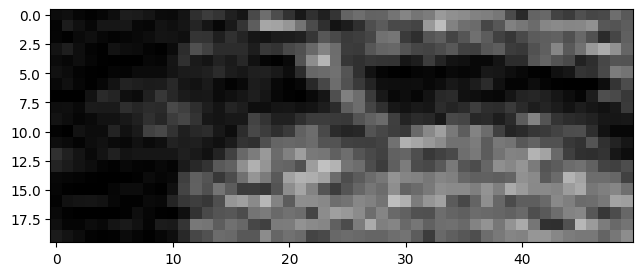

In [33]:
# mask = np.ones(img_0.shape)
# mask[30:, :] = 0
i = 0
img_0 = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)
img_0 = img_0[30:, :]
#imshow(img_0[30:, :])


In [39]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 7 # ODD
search_window_size = 35 # ODD! bigger than compare win

In [42]:
# load history
i = 0
img_0 = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)
img_0 = img_0[:, :30]

count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255))
    
denoised_img_0_incomplete = denoise_nlm_with_history_smart(img_0, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.6878845691680908s
2/50 rows done, elapsed time: 1.2473461627960205s
3/50 rows done, elapsed time: 1.8364176750183105s
4/50 rows done, elapsed time: 2.4756994247436523s
5/50 rows done, elapsed time: 3.1419248580932617s
6/50 rows done, elapsed time: 3.829766035079956s
7/50 rows done, elapsed time: 4.546295881271362s
8/50 rows done, elapsed time: 5.306798219680786s
9/50 rows done, elapsed time: 6.081362009048462s
10/50 rows done, elapsed time: 6.885983228683472s
11/50 rows done, elapsed time: 7.724862813949585s
12/50 rows done, elapsed time: 8.611645698547363s
13/50 rows done, elapsed time: 9.528807640075684s
14/50 rows done, elapsed time: 10.494518995285034s
15/50 rows done, elapsed time: 11.470204591751099s
16/50 rows done, elapsed time: 12.485866069793701s
17/50 rows done, elapsed time: 13.535322189331055s
18/50 rows done, elapsed time: 14.611304521560669s
19/50 rows done, elapsed time: 15.700050354003906s
20/50 rows done, elapsed time: 16.77004170417785

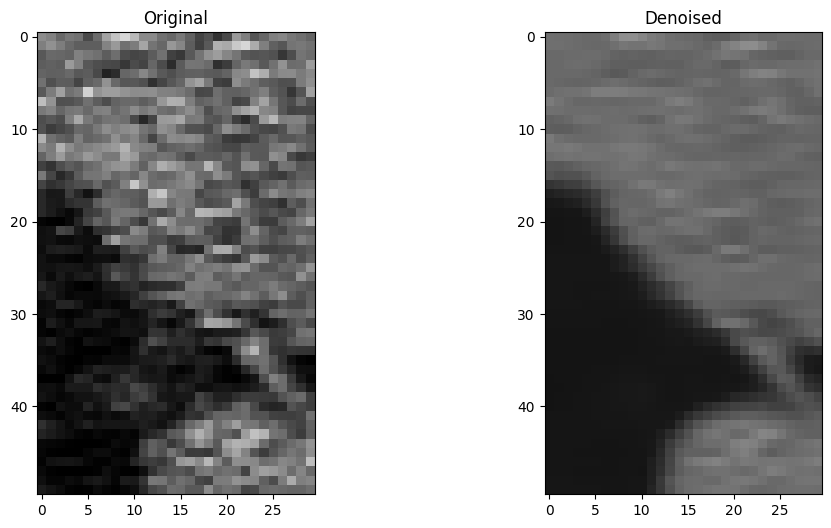

In [43]:
show_original_with_denoised(img_0, denoised_img_0_incomplete)

In [106]:
compare_img_quality(img_0, gt_img, denoised_img_0_incomplete)

# PSNR
  66.46068772206652
  72.07674464768704
# SSIM
  0.28493636298612834
  0.4003229075069186
# MSE
  0.01468965474817378
  0.004030935937574306


# Chaning the window size


In [45]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 7 # ODD
search_window_size = 35 # ODD! bigger than compare win

In [46]:
# load history
count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255))

In [47]:
denoised_img_smaller_sw = denoise_nlm_with_history(img_0, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 1.184528112411499s
2/50 rows done, elapsed time: 2.355943441390991s
3/50 rows done, elapsed time: 3.563877820968628s
4/50 rows done, elapsed time: 4.89504861831665s
5/50 rows done, elapsed time: 6.305713653564453s
6/50 rows done, elapsed time: 7.8084142208099365s
7/50 rows done, elapsed time: 9.342952251434326s
8/50 rows done, elapsed time: 11.032938718795776s
9/50 rows done, elapsed time: 12.716363906860352s
10/50 rows done, elapsed time: 14.410410404205322s
11/50 rows done, elapsed time: 16.307543516159058s
12/50 rows done, elapsed time: 18.05788278579712s
13/50 rows done, elapsed time: 19.95146155357361s
14/50 rows done, elapsed time: 22.191505670547485s
15/50 rows done, elapsed time: 24.360158920288086s
16/50 rows done, elapsed time: 26.359902143478394s
17/50 rows done, elapsed time: 28.455599308013916s
18/50 rows done, elapsed time: 30.529720783233643s
19/50 rows done, elapsed time: 32.78249454498291s
20/50 rows done, elapsed time: 34.97613048553467s


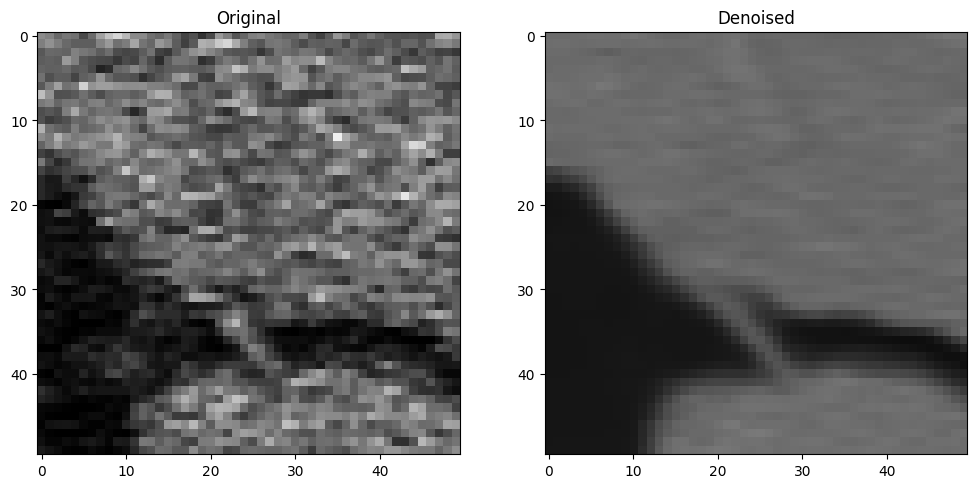

In [38]:
show_original_with_denoised(img_0, denoised_img_smaller_sw)

In [87]:
compare_img_quality(crop(img_float), gt_img, denoised_img_smaller_sw)

# PSNR
  66.46068772206652
  65.53907533763254
# SSIM
  0.28493636298612834
  0.11657054262900185
# MSE
  0.01468965474817378
  0.018162382893988978


In [52]:
compare_img_quality(img_0, gt_img, denoised_img_0)

# PSNR
  66.46068772206652
  72.74926878338151
# SSIM
  0.28493636298612834
  0.40764471879818776
# MSE
  0.01468965474817378
  0.003452657369622392


In [18]:
i = 0
cropped_img = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255, 30)

# load history
count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255, 30))
    
denoised_cropped_img = denoise_nlm_with_history(cropped_img, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.8013525009155273s
2/50 rows done, elapsed time: 1.4279108047485352s
3/50 rows done, elapsed time: 2.1058437824249268s
4/50 rows done, elapsed time: 2.823822021484375s
5/50 rows done, elapsed time: 3.5985896587371826s
6/50 rows done, elapsed time: 4.430833101272583s
7/50 rows done, elapsed time: 5.305182933807373s
8/50 rows done, elapsed time: 6.227389574050903s
9/50 rows done, elapsed time: 7.199337959289551s
10/50 rows done, elapsed time: 8.214565992355347s
11/50 rows done, elapsed time: 9.274018287658691s
12/50 rows done, elapsed time: 10.396619081497192s
13/50 rows done, elapsed time: 11.598276853561401s
14/50 rows done, elapsed time: 12.846779346466064s
15/50 rows done, elapsed time: 14.067273616790771s
16/50 rows done, elapsed time: 15.280098676681519s
17/50 rows done, elapsed time: 16.51449155807495s
18/50 rows done, elapsed time: 17.725853204727173s
19/50 rows done, elapsed time: 18.962097883224487s
20/50 rows done, elapsed time: 20.19954514503479

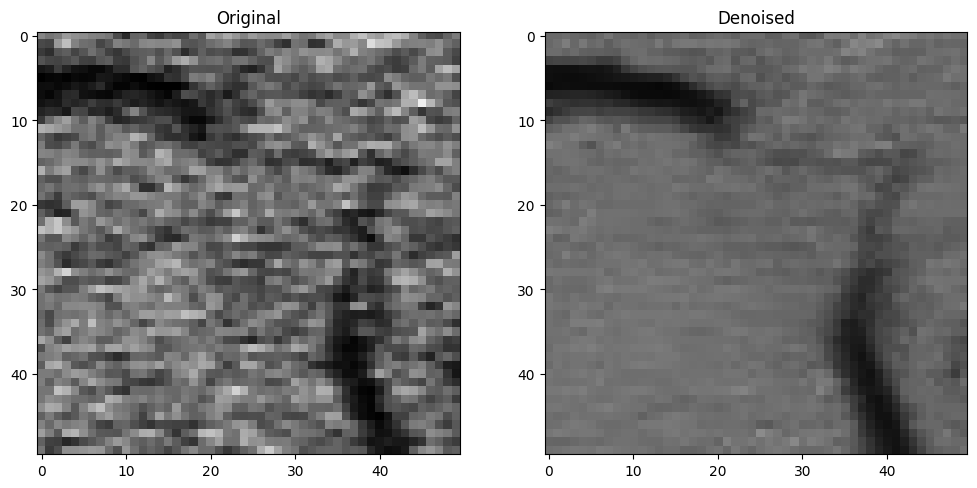

In [19]:
show_original_with_denoised(cropped_img, denoised_cropped_img)

In [17]:
denoised_img_new = denoise_nlm(img_0, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.3085012435913086s
2/50 rows done, elapsed time: 0.4245905876159668s
3/50 rows done, elapsed time: 0.5531940460205078s
4/50 rows done, elapsed time: 0.6900358200073242s
5/50 rows done, elapsed time: 0.8362479209899902s
6/50 rows done, elapsed time: 0.9909019470214844s
7/50 rows done, elapsed time: 1.16127347946167s
8/50 rows done, elapsed time: 1.3341538906097412s
9/50 rows done, elapsed time: 1.5215680599212646s
10/50 rows done, elapsed time: 1.7294025421142578s
11/50 rows done, elapsed time: 2.019249677658081s
12/50 rows done, elapsed time: 2.2409796714782715s
13/50 rows done, elapsed time: 2.4557178020477295s
14/50 rows done, elapsed time: 2.6842525005340576s
15/50 rows done, elapsed time: 2.9153854846954346s
16/50 rows done, elapsed time: 3.151590585708618s
17/50 rows done, elapsed time: 3.3805418014526367s
18/50 rows done, elapsed time: 3.608982563018799s
19/50 rows done, elapsed time: 3.8393616676330566s
20/50 rows done, elapsed time: 4.068099737167

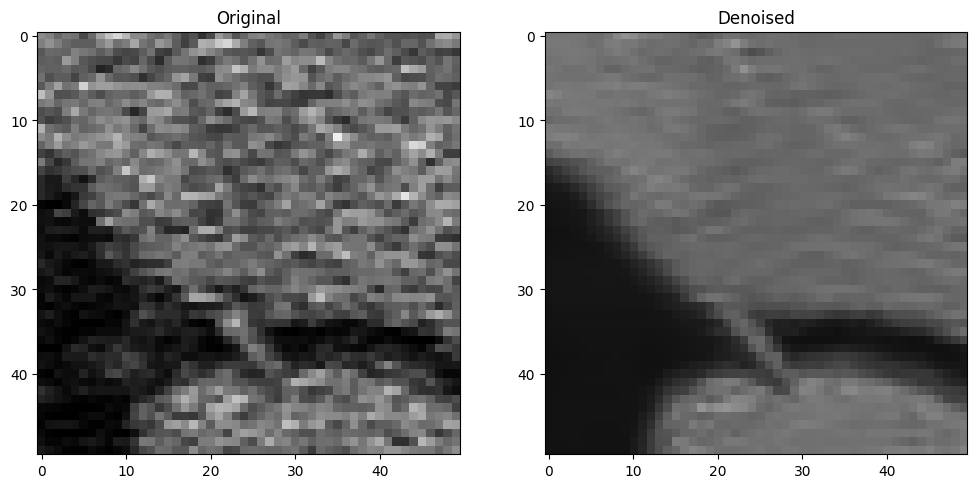

In [18]:
show_original_with_denoised(img_0, denoised_img_new)

# Different approach to history  
Instead of just performing separate NLM filter for each image in history and then averaging the result,  
now we perform 

In [25]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 7 # ODD
search_window_size = 35 # ODD! bigger than compare win

In [13]:
# load history
i = 0
cropped_original_img = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)

count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255))
        
denoised_img_smart = denoise_nlm_with_history_smart(cropped_original_img, history, search_window_size, compare_window_size, strength, sd, 1)

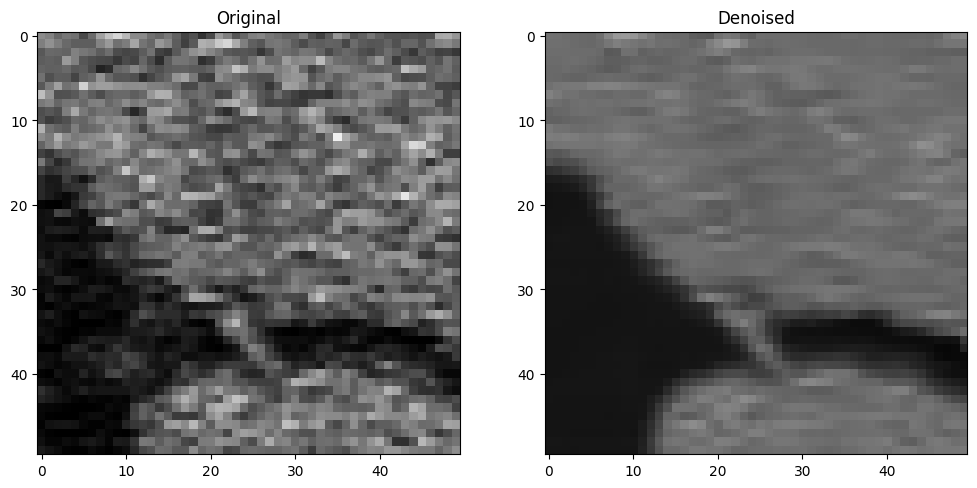

In [14]:
show_original_with_denoised(cropped_original_img, denoised_img_smart)

In [15]:
compare_img_quality(cropped_original_img, gt_img, denoised_img_smart)

# PSNR
  66.46068772206652
  71.01408418633497
# SSIM
  0.28493636298612834
  0.3765180547629926
# MSE
  0.01468965474817378
  0.005148395976516616


# Smart history, but on different input


In [26]:
# PARAMETERS
sd = 0.2632 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 9 # ODD
search_window_size = 35 # ODD! bigger than compare win
compare_window_offset = int((compare_window_size - 1) // 2)


In [27]:
samples100x100_folder_prefix = '/home/martinb/SCHOOL/pv162_project/data/input_images/100x100_100ns_shifted/'

# noisy_img
noisy_img = (imread(samples100x100_folder_prefix + f"{0}.png", as_gray=True).astype(np.float64)) / 255
noisy_img = create_padded_img(noisy_img, compare_window_offset)

# gt_img
gt_img_full = imread("/home/martinb/SCHOOL/pv162_project/data/input_images/sample_512.png", as_gray=True).astype(np.float64) / 255
gt_img = shift_gt_img(gt_img_full, 0)


history = []
for c in range(1, 1 + 5):
    history.append(create_padded_img(
        (imread(samples100x100_folder_prefix + f"{c}.png", as_gray=True).astype(np.float64)) / 255, compare_window_offset))
    
    


In [28]:
denoised_img = denoise_nlm_with_history_smart(noisy_img, history, search_window_size, compare_window_size,
                                                          strength, sd, 1, True)

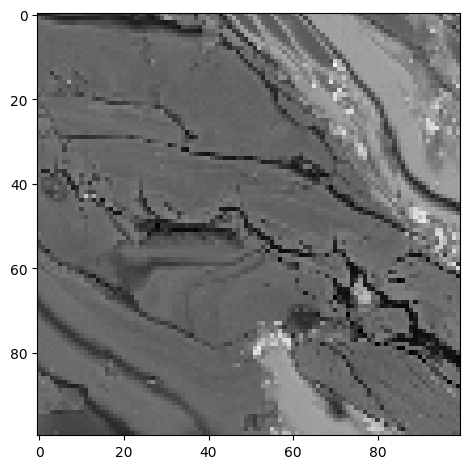

In [46]:
shift = 0
width = 100
height = 100
left = 512 - 150
top = 512-170
im = gt_img_full[top + shift : top + height + shift,
                  left + shift : left + width + shift]
imshow(im)

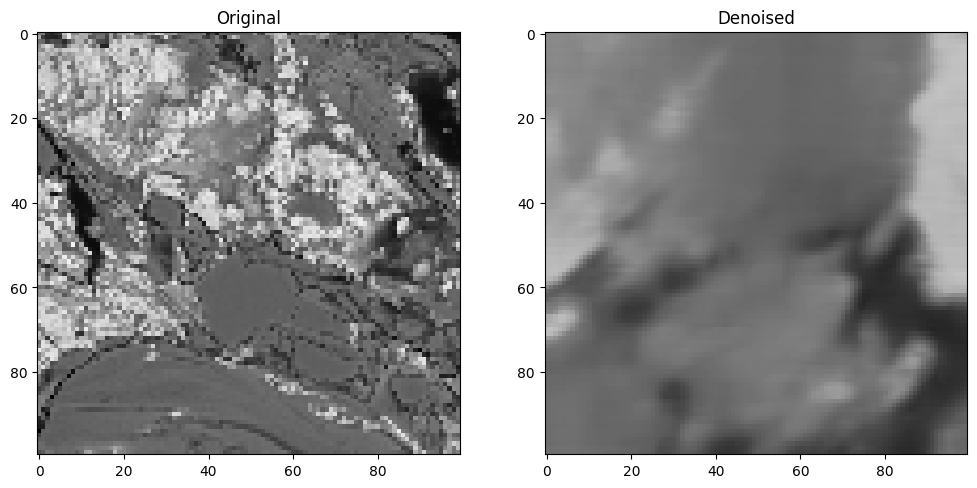

In [29]:
#imshow(denoised_img)
show_original_with_denoised(gt_img, denoised_img)

# GPU optimizations

In [21]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 7 # ODD
search_window_size = 35 # ODD! bigger than compare win

compare_window_offset = int((compare_window_size - 1) // 2)
img_width = 50
img_heigth = 50
img_width_padded = img_width + 2 * compare_window_offset
img_heigth_padded = img_heigth + 2 * compare_window_offset

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
i = 0
cropped_original_img = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)
tensor_original_img = torch.from_numpy(create_padded_img(cropped_original_img, compare_window_offset))
tensor_original_img = tensor_original_img.to(device)

# load history
count = 5
history = torch.empty((count, img_heigth_padded, img_width_padded))
for c in range(1, 1 + count):
    history[c - 1] = torch.from_numpy(create_padded_img(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255), compare_window_offset))
    history[c - 1] = history[c - 1].to(device)
        
gpu_denoised_img_smart = gpu_denoise_nlm_with_history_smart(tensor_original_img, history, search_window_size, compare_window_size, strength, sd)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/martinb/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_12750/82585675.py", line 13, in <module>
    gpu_denoised_img_smart = gpu_denoise_nlm_with_history_smart(tensor_original_img, history, search_window_size, compare_window_size, strength, sd)
  File "/home/martinb/SCHOOL/pv162_project/nlm.py", line 252, in gpu_denoise_nlm_with_history_smart
    calculate_pixel_denoised_value_between_images(img, history_images[img_i], img_width, img_height,
  File "/home/martinb/SCHOOL/pv162_project/nlm.py", line 138, in calculate_pixel_denoised_value_between_images
    d2 = calculate_distance_squared_between_images(padded_img1, x, y, padded_img2,
  File "/home/martinb/SCHOOL/pv162_project/nlm.py", line 28, in calculate_distance_squared_between_images
    tensor_sum += torch.square(image1[y1 + f, x1 + f] - image2[y2 + f, x2 + f

# Reducing Search Window size
- This process may introduce spilling of colors, as shown above. 
- To find where is the "border" between number of history images and search window size is very problematic


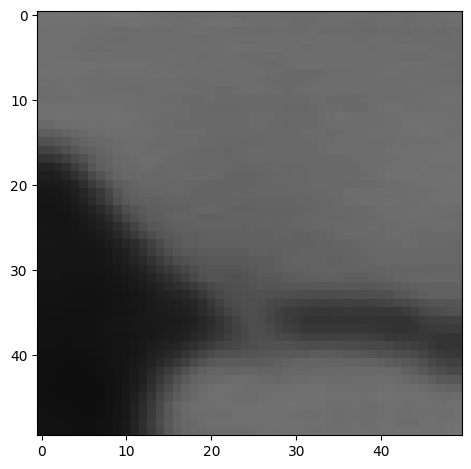

In [11]:
strength = 40
compare_window_size = 9
search_window_size = 27

cv_denoised_img = cv.fastNlMeansDenoising((img_0 * 255).astype(np.uint8), None, strength, compare_window_size, search_window_size)
imshow(cv_denoised_img)

In [13]:
# strength = 20
# noise_sd = 10
# compare_window_size = 31
# search_window_size = 101
#
# search_window_offset = int((search_window_size - 1) // 2)
# compare_window_offset = int((compare_window_size - 1) // 2)
# y_search_min = max(compare_window_offset,15 - search_window_offset)
# print(y_search_min)
#
# cv_denoised_img = cv.fastNlMeansDenoising(img, None, strength, compare_window_size, search_window_size)
# my_denoised_img = denoise_nlm(img, search_window_size, compare_window_size, strength, noise_sd)
#
#
# plt.figure(figsize=(12,6))
# plt.subplot(121).title.set_text('OpenCV NLM'), plt.imshow(cv_denoised_img, cmap='gray', vmin=0, vmax=255)
# plt.subplot(122).title.set_text('My NLM'), plt.imshow(my_denoised_img, cmap='gray', vmin=0, vmax=255)
# plt.show()

In [5]:
from PIL import Image
import numpy
import array
import sys
import random

arg_img_in = f"/home/martinb/SCHOOL/pv162_project/data/input_images/sample_1024.png"
input_img = Image.open(arg_img_in).convert('L')
(input_img_w, input_img_h) = input_img.size
left = input_img_w // 4
top = input_img_h // 4
right = input_img_w - left
bottom = input_img_h - top

rand_shift_w = random.randint(-50, 50)
rand_shift_h = random.randint(-50, 50)

img_in = input_img.crop((left + rand_shift_w, top + rand_shift_h, right + rand_shift_w, bottom + rand_shift_h))
(img_w, img_h) = img_in.size

img_in.show()

kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-mng"
org.kde.kdegraphics.gwenview.lib: Unresolved raw mime type  "image/x-nikon-nrw"
org.kde.kdegraphics.gwenview.lib: Unresolved raw mime type  "image/x-samsung-srw"
